# SPR data models
This notebook is to collaborate on modelling enzyme kinetics on SPR data.

## Reversible and irreversible binding model
ref: https://pubmed.ncbi.nlm.nih.gov/22966968/

$$
E_{bulk} + \Gamma_O \underset{k_{\text{off}}}{\overset{k_{\text{on}}}{\leftrightarrows}} \Gamma_E \overset{k_I}{\rightarrow} \Gamma_I
$$

In [11]:
#@title  **download and unzip data**</font>
!rm SPR_data.zip*
!wget https://github.com/gcourtade/masters/raw/refs/heads/main/2025/CK_SPR/SPR_data.zip
!unzip -P hI9Ht4CjalNmTo SPR_data.zip

--2025-03-28 07:03:15--  https://github.com/gcourtade/masters/raw/refs/heads/main/2025/CK_SPR/SPR_data.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gcourtade/masters/refs/heads/main/2025/CK_SPR/SPR_data.zip [following]
--2025-03-28 07:03:16--  https://raw.githubusercontent.com/gcourtade/masters/refs/heads/main/2025/CK_SPR/SPR_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86069 (84K) [application/zip]
Saving to: ‘SPR_data.zip’

SPR_data.zip        100%[===================>]  84.05K  --.-KB/s    in 0.02s   

2025-03-28 07:03:16 (4.91 MB/s) - ‘SPR_data.zip’ saved [86069/86069]

Ar

In [12]:
#@title  **import packages and define functions**</font>
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.integrate import odeint
import os

def process_data(time, R, time_max=3600, plot_this=False):
    time_cut = time[time < time_max]
    R_cut = R[time < time_max]

    xmin=0

    # Optional: Smooth the data to reduce noise using Savitzky-Golay filter
    window_length = 51  # Must be an odd number; adjust as needed
    polyorder = 3
    R_cut_smooth = savgol_filter(R_cut, window_length, polyorder)

    if plot_this:
    # Plot the original and smoothed data to visualize smoothing effect
        plt.figure(figsize=(10, 6))
        plt.plot(time_cut, R_cut, label='Original Data', alpha=0.5)
        plt.plot(time_cut, R_cut_smooth, label='Smoothed Data', linewidth=2)
        plt.xlabel('Time')
        plt.ylabel('Signal')
        plt.title('Signal vs Time (Cut Data)')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Step 2: Calculate the derivative of the smoothed data
    dR_dt = np.gradient(R_cut_smooth, time_cut)

    if plot_this:
    # Plot the derivative to visualize where the signal starts to rise
        plt.figure(figsize=(10, 6))
        plt.plot(time_cut, dR_dt)
        plt.xlabel('Time')
        plt.ylabel('dR/dt')
        plt.title('Derivative of Signal vs Time')
        plt.grid(True)
        plt.show()

    # Set a threshold for the derivative to detect where the baseline ends
    # Adjust the threshold based on your data characteristics
    threshold = np.max(dR_dt) * 0.2  # For example, 20% of the maximum derivative

    # Find the index where the derivative first exceeds the threshold
    baseline_end_indices = np.where(dR_dt > threshold)[0]

    if len(baseline_end_indices) > 0:
        baseline_end_index = baseline_end_indices[0]
        t_baseline_end = time_cut[baseline_end_index]
        print(f"Automatically detected t_baseline_end at time {t_baseline_end}")
    else:
        print("Could not automatically detect t_baseline_end; defaulting to xmin")
        t_baseline_end = xmin

    # Step 3: Normalize the data using R_normalized(t) = (R(t) - R_baseline) / (R_max - R_baseline)
    # Calculate R_baseline as the mean of R_cut during the baseline period
    baseline_indices = np.where(time_cut <= t_baseline_end)
    R_baseline = np.mean(R_cut[baseline_indices[0]])

    # Calculate R_max as the maximum value of R_cut after the baseline
    post_baseline_indices = np.where(time_cut > t_baseline_end)
    R_max = np.max(R_cut[post_baseline_indices[0]])

    # Normalize R(t)
    R_normalized = (R_cut - R_baseline) / (R_max - R_baseline)

    # Step 4: Cut off the initial flat (baseline) part
    # Extract data after t_baseline_end
    time_final = time_cut[post_baseline_indices[0]]
    R_normalized_final = R_normalized[post_baseline_indices[0]]

    # Rescale the time axis to start at zero at t_baseline_end
    time_rescaled = time_final - t_baseline_end
    t_signal_start = np.gradient(R_normalized_final, time_rescaled).argmax()
    R_normalized_final_tmp = R_normalized_final.values[t_signal_start:]
    while R_normalized_final_tmp[0]>0.1:
        t_signal_start -= 1
        R_normalized_final_tmp = R_normalized_final.values[t_signal_start:]
    time_rescaled = time_rescaled.values[t_signal_start:]
    R_normalized_final = R_normalized_final_tmp

    if plot_this:
    # Plot the final normalized data with rescaled time axis
        plt.figure(figsize=(10, 6))
        plt.plot(time_rescaled, R_normalized_final)
        plt.xlabel('Time since baseline end')
        plt.ylabel('Normalized Signal')
        plt.title('Normalized Signal vs Time (After Baseline Removal)')
        plt.grid(True)
        plt.show()
    return time_rescaled, R_normalized_final, R_max

def enzyme_adsorption_model(y, t, ka, kd, ki, Gamma_max, transition_time):
    """
    ODE system for enzyme adsorption with reversible and irreversible binding
    y[0] = Gamma_E (reversibly bound enzyme)
    y[1] = Gamma_I (irreversibly bound enzyme)
    """
    Gamma_E, Gamma_I = y
    Gamma_0 = Gamma_max - Gamma_E - Gamma_I  # Available binding sites

    # During adsorption phase, E_bulk > 0
    if t < transition_time:
        dGamma_E_dt = ka * E_bulk * Gamma_0 - kd * Gamma_E - ki * Gamma_E
        dGamma_I_dt = ki * Gamma_E
    # During washoff phase, E_bulk = 0
    else:
        dGamma_E_dt = -kd * Gamma_E - ki * Gamma_E
        dGamma_I_dt = ki * Gamma_E

    return [dGamma_E_dt, dGamma_I_dt]

# Function to simulate the complete adsorption and washoff process
def simulate_adsorption_washoff(t, ka, kd, ki, Gamma_max, transition_time):
    # Initial conditions: no bound enzyme
    y0 = [0.0, 0.0]  # [Gamma_E, Gamma_I]

    # Solve the ODE system
    solution = odeint(enzyme_adsorption_model, y0, t, args=(ka, kd, ki, Gamma_max, transition_time))

    # Total surface enzyme = reversibly bound + irreversibly bound
    Gamma_T = solution[:, 0] + solution[:, 1]

    return Gamma_T



def MSE(params,x_data,y_data):
    "to calclate mean square error, this is the same as your func_error"
    return ((simulate_adsorption_washoff(x_data,*params)-y_data)**2).mean()

def fit_model(time_rescaled, R_normalized_final, E_bulk=5e-6, plot_this=False):
    # Define the ODE system based on equations 2 and 3

    besterror = 10000
    bestpopt = None

    for kon_ in np.arange(5000,20000,1000):
        for tt_ in np.arange(480,1400,20):
            # grid search for parameter c between 5 and 100, step size is 1.
            popt, pcov = curve_fit(simulate_adsorption_washoff,
                            time_rescaled,
                            R_normalized_final,
                            p0=[kon_, 0.01, 0, 1.0, tt_],  # Initial guesses for ka, kd, ki, Gamma_max, transition_time
                            bounds=([kon_, 0, 0, 0, tt_], [kon_+1000, 0.1, 0.1, 2, tt_+1]))  # Reasonable bounds

            error = MSE(popt,time_rescaled,R_normalized_final)
            if error<besterror:
                besterror = error
                bestpopt = popt

    return bestpopt, error

    # Fit the entire dataset with a single set of parameters

def plot_best_popt(bestpopt, x_data, y_data):

    ka_fitted, kd_fitted, ki_fitted, Gamma_max_fitted, transition_time_fitted = bestpopt
    print(f"Fitted parameters:")
    print(f"kon (M-1 s-1): {ka_fitted:.6f}")
    print(f"koff (s-1): {kd_fitted:.6f}")
    print(f"ki (s-1): {ki_fitted:.6f}")
    print(f"Gamma_max: {Gamma_max_fitted:.6f}")
    print(f"transition_time (s): {transition_time_fitted:.6f}")


    error = MSE(bestpopt, x_data, y_data)
    print(f"MSE: {error:.6f}")


    # Decompose the result to show Gamma_E and Gamma_I separately
    solution = odeint(enzyme_adsorption_model, y0=[0, 0], t=x_data, args=(ka_fitted, kd_fitted, ki_fitted, Gamma_max_fitted, transition_time_fitted))
    Gamma_E = solution[:, 0]
    Gamma_I = solution[:, 1]
    Gamma_T = (Gamma_E + Gamma_I)

    plt.figure(figsize=(12, 6))
    plt.plot(x_data, y_data, 'o', alpha=0.5, label='Experimental data')
    plt.plot(x_data, Gamma_E, 'g-', linewidth=2, label='Reversibly bound (Γ_E)')
    plt.plot(x_data, Gamma_I, 'b-', linewidth=2, label='Irreversibly bound (Γ_I)')
    plt.plot(x_data, Gamma_T, 'r-', linewidth=2, label='Total bound (Γ_T)')

    plt.axvline(x=transition_time_fitted, color='k', linestyle='--',
                label=f'Washoff at {transition_time_fitted:.1f} min')

    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Normalized signal', fontsize=14)
    plt.title('Decomposition of Enzyme Binding into Reversible and Irreversible Components', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()




E_bulk: 5.00e-06 M
Automatically detected t_baseline_end at time 878.1899999999999
Fitted parameters:
kon (M-1 s-1): 7067.363114
koff (s-1): 0.000920
ki (s-1): 0.000977
Gamma_max: 1.001835
transition_time (s): 600.514062
MSE: 0.000279


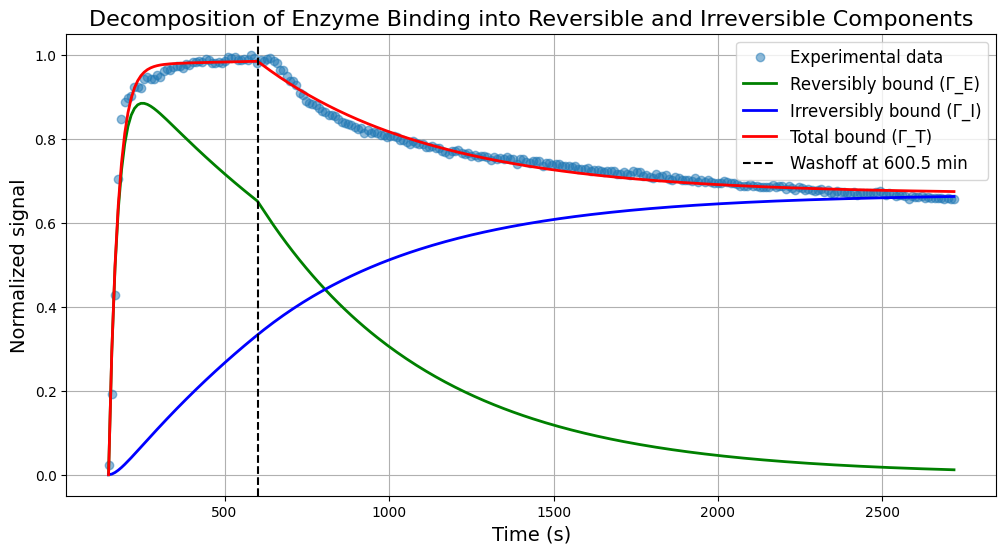

E_bulk: 3.00e-06 M
Automatically detected t_baseline_end at time 1005.2819999999999
Fitted parameters:
kon (M-1 s-1): 13031.665303
koff (s-1): 0.000772
ki (s-1): 0.000945
Gamma_max: 0.997431
transition_time (s): 600.053153
MSE: 0.000262


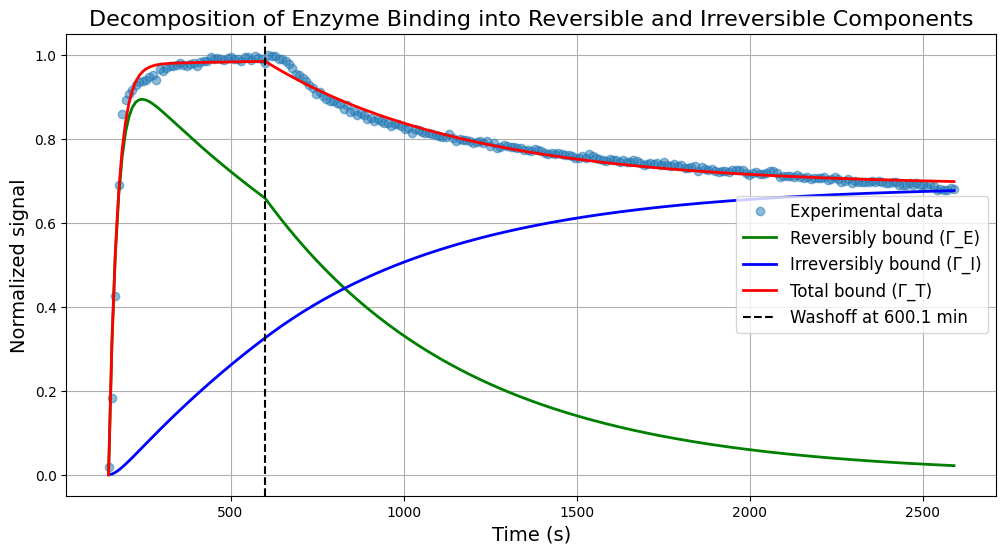

E_bulk: 5.00e-07 M
Automatically detected t_baseline_end at time 965.394
Fitted parameters:
kon (M-1 s-1): 10202.684141
koff (s-1): 0.000361
ki (s-1): 0.002315
Gamma_max: 1.158812
transition_time (s): 540.063206
MSE: 0.000257


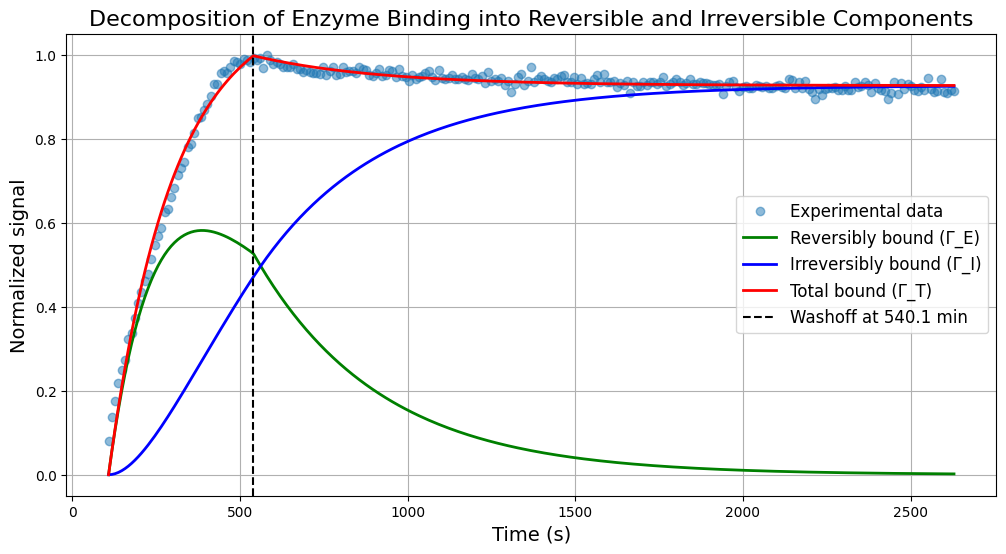

E_bulk: 7.00e-07 M
Automatically detected t_baseline_end at time 916.2059999999999
Fitted parameters:
kon (M-1 s-1): 19003.987163
koff (s-1): 0.094667
ki (s-1): 0.025974
Gamma_max: 1.389828
transition_time (s): 580.842876
MSE: 0.000195


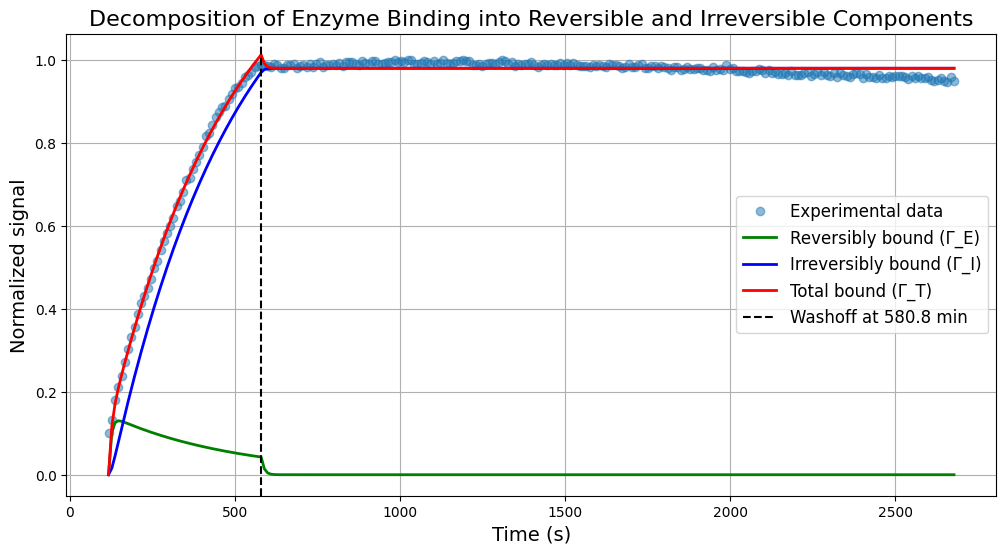

E_bulk: 1.00e-06 M
Automatically detected t_baseline_end at time 964.3259999999999
Fitted parameters:
kon (M-1 s-1): 5147.954682
koff (s-1): 0.000666
ki (s-1): 0.001079
Gamma_max: 1.245468
transition_time (s): 500.073698
MSE: 0.000581


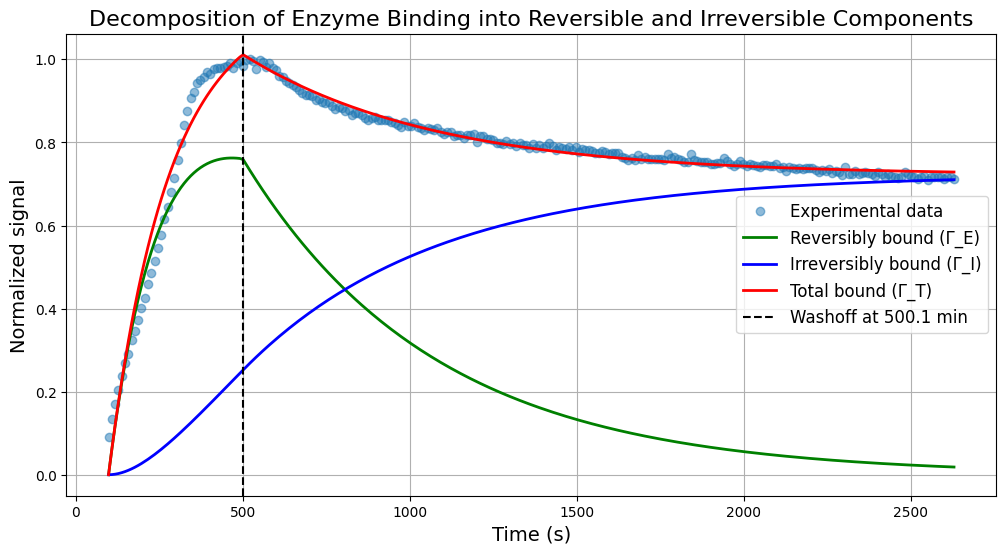

E_bulk: 2.00e-07 M
Automatically detected t_baseline_end at time 336.0498
Fitted parameters:
kon (M-1 s-1): 19751.684170
koff (s-1): 0.000987
ki (s-1): 0.002596
Gamma_max: 1.592883
transition_time (s): 1160.119469
MSE: 0.001156


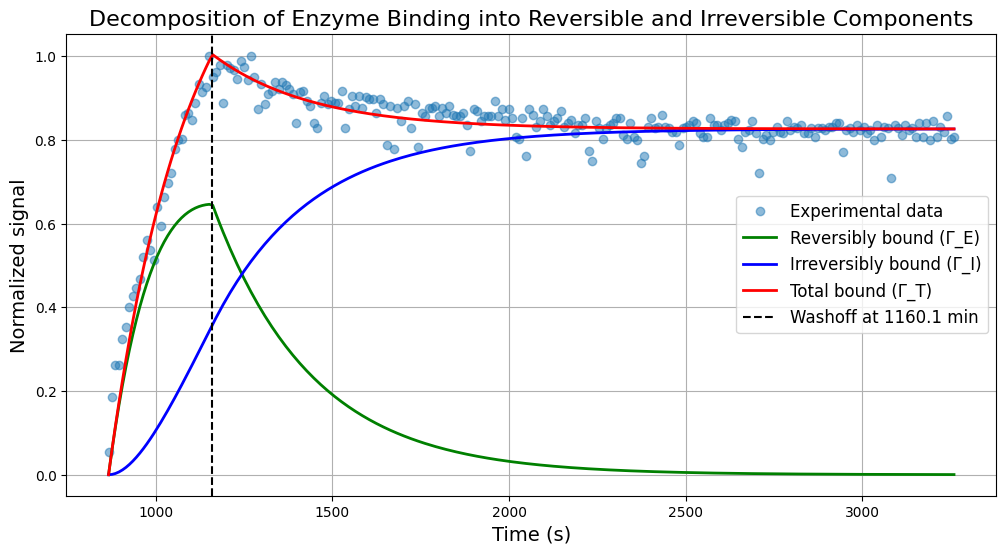

In [13]:
#@title  **analyze data**</font>

file_list = []
data_dir = 'SPR_data'
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if '0.25% PET' in file:
            file_list.append(file)
results = {
    'kon': [],
    'koff': [],
    'ki':[],
    'Gamma_max':[],
    'transition_time':[],
    'E_bulk': [],
    'R_max': [],
    'time_rescaled':[],
    'R_normalized_final':[],
    'MSE':[]
}

for file in file_list:
    E_bulk = float(file.split('-')[2].split(' ')[1])*1e-6 # in M
    print(f'E_bulk: {E_bulk:.2e} M')
    df = pd.read_csv(f'{data_dir}/{file}', sep='\t', decimal=',')
    time = df[df.columns[2]]*60
    R = df[df.columns[3]]
    #plt.plot(time, R)
    time_rescaled, R_normalized_final, R_max = process_data(time, R)
    bestpopt, error = fit_model(time_rescaled, R_normalized_final, E_bulk)
    results['kon'].append(bestpopt[0])
    results['koff'].append(bestpopt[1])
    results['ki'].append(bestpopt[2])
    results['Gamma_max'].append(bestpopt[3])
    results['transition_time'].append(bestpopt[4])
    results['MSE'].append(error)
    results['E_bulk'].append(E_bulk)
    results['R_max'].append(R_max)
    results['R_normalized_final'].append(R_normalized_final)
    results['time_rescaled'].append(time_rescaled)
    plot_best_popt(bestpopt, time_rescaled, R_normalized_final)


In [14]:
results_df = pd.DataFrame(results)
results_df.head()

,kon,koff,ki,Gamma_max,transition_time,E_bulk,R_max,time_rescaled,R_normalized_final,MSE
0,7067.363114,0.000920,0.000977,1.001835,600.514062,5.000000e-06,73.6556,"[147.39600000000007, 157.24800000000016, 167.0...","[0.02317005504951103, 0.1915698779932504, 0.42...",0.006719
1,13031.665303,0.000772,0.000945,0.997431,600.053153,3.000000e-06,73.6386,"[147.54600000000005, 157.3499999999999, 167.19...","[0.01880789594189737, 0.18325044790266104, 0.4...",0.004557
2,10202.684141,0.000361,0.002315,1.158812,540.063206,5.000000e-07,73.3875,"[108.23399999999992, 118.03800000000001, 127.8...","[0.08028894546751209, 0.1373477806067204, 0.17...",0.001693
3,19003.987163,0.094667,0.025974,1.389828,580.842876,7.000000e-07,73.4964,"[118.06200000000013, 127.90200000000027, 137.7...","[0.09936207514641388, 0.13270212003197177, 0.1...",0.001115
4,5147.954682,0.000666,0.001079,1.245468,500.073698,1.000000e-06,73.6112,"[98.27400000000023, 108.12600000000009, 117.96...","[0.09168296975689616, 0.13333473574968177, 0.1...",0.010343


In [15]:
results_df['KD'] = (results_df['koff']+results_df['ki'])/results_df['kon']
results_df[results_df['E_bulk'] >= 1.0e-6].describe()

,kon,koff,ki,Gamma_max,transition_time,E_bulk,R_max,MSE,KD
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000e+00
mean,8415.661033,0.000786,0.001000,1.081578,566.880305,0.000003,73.635133,0.007206,2.463765e-07
std,4111.162092,0.000128,0.000070,0.141950,57.856677,0.000002,0.022402,0.002924,1.053813e-07
min,5147.954682,0.000666,0.000945,0.997431,500.073698,0.000001,73.611200,0.004557,1.317233e-07
25%,6107.658898,0.000719,0.000961,0.999633,550.063426,0.000002,73.624900,0.005638,2.000624e-07
50%,7067.363114,0.000772,0.000977,1.001835,600.053153,0.000003,73.638600,0.006719,2.684014e-07
75%,10049.514208,0.000846,0.001028,1.123651,600.283608,0.000004,73.647100,0.008531,3.037031e-07
max,13031.665303,0.000920,0.001079,1.245468,600.514062,0.000005,73.655600,0.010343,3.390048e-07


In [16]:
kin_kd = results_df[results_df['E_bulk'] >= 1.0e-6].describe().loc['mean', 'KD']*1e6
kin_kd_err = results_df[results_df['E_bulk'] >= 1.0e-6].describe().loc['std', 'KD']*1e6

print(f'Kinetic KD: {kin_kd:.3f} +/- {kin_kd_err:.3f} µM')


Kinetic KD: 0.246 +/- 0.105 µM


Equilibrium KD: 1.08 +/- 0.65 µM


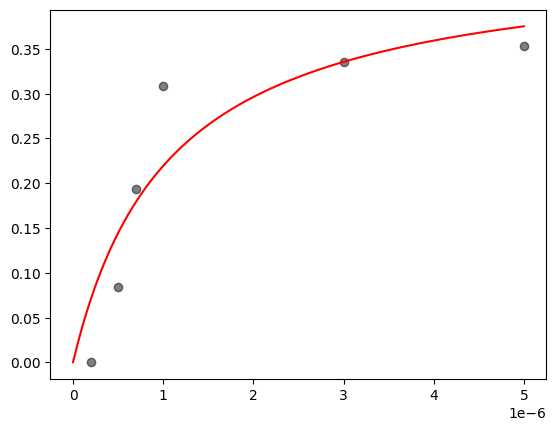

In [17]:
def langmuir(E,KD,Qmax):
    return E*Qmax/(KD+E)

x = results_df['E_bulk'].values
y = results_df['R_max'].values
y = y - y.min()
popt, pcov = curve_fit(langmuir, x, y)
perr = np.sqrt(np.diag(pcov))
print(f'Equilibrium KD: {popt[0]*1e6:.2f} +/- {perr[0]*1e6:.2f} µM')
plt.plot(x,y,'ko',alpha=0.5, label='data')
xmodel = np.linspace(0, x.max(), num=100)
plt.plot(xmodel, langmuir(xmodel, *popt), 'r-', label='fit')
plt.show()